In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [381]:
data = pd.read_csv("data.csv")
data.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA


In [ ]:
data.drop(['country'],axis=1,inplace=True)
data.drop(['date'],axis=1, inplace=True)
data.drop(['street'],axis=1, inplace=True)
data.drop(['statezip'],axis=1, inplace=True)
data.isna().sum()


price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
city             0
dtype: int64

In [383]:
from datetime import datetime

# Current year
current_year = datetime.now().year

# Convert year built → house age
data['House_Age'] = current_year - data['yr_built'] 
data['temp'] = np.where(data['yr_renovated'] > 0, data['yr_renovated'] - data['yr_built'], 0)
data['House_Age'] = data['House_Age'] - data['temp']
data.drop(['yr_built', 'yr_renovated','temp'], axis=1, inplace=True)
data.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,city,House_Age
0,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,Shoreline,20
1,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,Seattle,104
2,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,Kent,59


In [384]:
# data['sft'] = data['sqft_living'] + data['sqft_lot']
# data.drop(['sqft_living', 'sqft_lot'], axis=1, inplace=True)
# data.head(3)

In [385]:
import pandas as pd

# Calculate Q1 and Q3
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 1.2 * IQR

# Filter out outliers
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

print(f"Remaining rows after removing outliers: {len(data)}")


Remaining rows after removing outliers: 4186


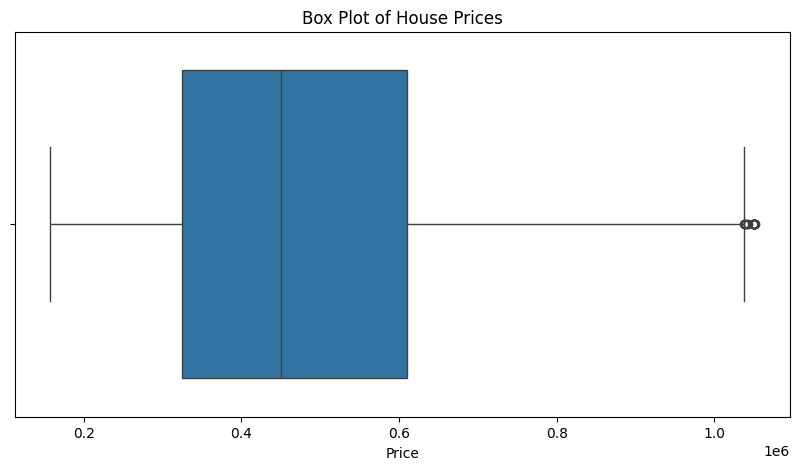

In [386]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=data['price'])  # or np.log1p(df['price'])
plt.title("Box Plot of House Prices")
plt.xlabel("Price")
plt.show()


In [387]:
y = data['price']
X = data.drop(['price'],axis=1)

In [388]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [389]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

encoder = TargetEncoder(cols=[ 'city'], smoothing=0.3)

# Fit on training data only
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Transform test set using mapping from training data
X_test_encoded = encoder.transform(X_test)


In [390]:
X_train_encoded.head(3)
y_train.head(2)

1426    267000.0
2356    329950.0
Name: price, dtype: float64

In [391]:
scaler = StandardScaler()

# Fit on training data only
numeric_cols = ['city', 'sqft_living', 'sqft_lot' , 'bedrooms', 'bathrooms', 'floors', 'House_Age', 'sqft_above', 'sqft_basement', 'waterfront', 'view', 'condition']
X_train_encoded[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])

# Transform test data
X_test_encoded[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])


In [392]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.9,
    reg_lambda=1,
    reg_alpha=0.1
)

model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


MAE: 76404.85233898807
RMSE: 106585.29534437231
R²: 0.7239211306290788


In [393]:
from xgboost import XGBRegressor

importances = model.feature_importances_
features = X_train_encoded.columns
sorted(zip(importances, features), reverse=True)


[(0.26626834, 'sqft_living'),
 (0.2637279, 'city'),
 (0.09418919, 'sqft_above'),
 (0.061974067, 'view'),
 (0.05046341, 'waterfront'),
 (0.050268408, 'sqft_basement'),
 (0.04777202, 'condition'),
 (0.038190305, 'sqft_lot'),
 (0.037173633, 'floors'),
 (0.035318453, 'bathrooms'),
 (0.031479053, 'House_Age'),
 (0.023175156, 'bedrooms')]

In [394]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring='r2')
print("Cross-Validation R² scores:", scores)
print("Average R²:", scores.mean())


Cross-Validation R² scores: [0.67119811 0.6946337  0.6790677  0.7208779  0.69301708]
Average R²: 0.6917588980675722


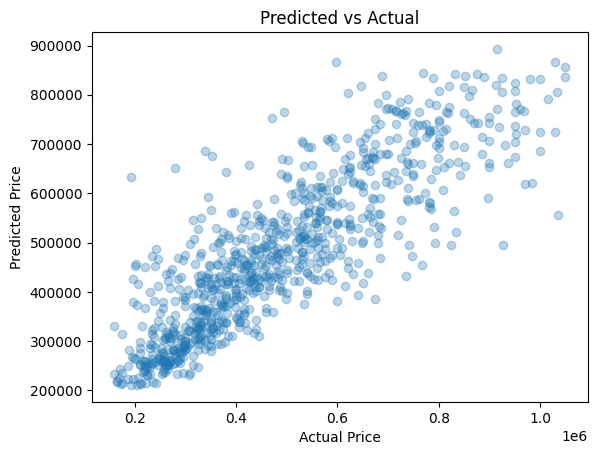

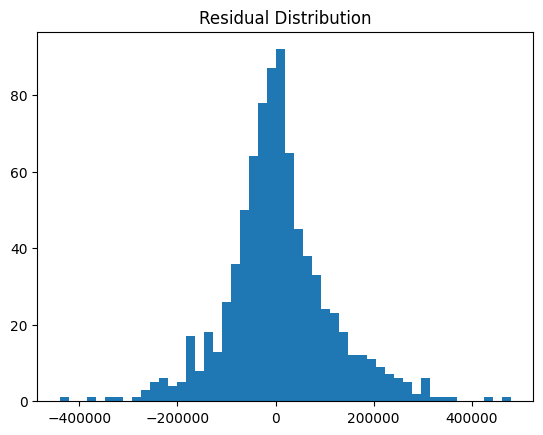

In [395]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual")
plt.show()

residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()
